In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from google.colab import files



In [ ]:
# 2. Upload CSV file
uploaded = files.upload()  # This will open a file picker



Saving merged_data 1.csv to merged_data 1.csv


In [ ]:
# 3. Load Data
merged_df = pd.read_csv("merged_data 1.csv")

# Quick check
print(merged_df.head())
print(merged_df.info())



   course_id course_type_broad   unit_id  unit_level_code unit_level_name  \
0     2951.0     Undergraduate  182243.0              0.0           Other   
1     2951.0     Undergraduate  213920.0              0.0           Other   
2     2951.0     Undergraduate  220770.0              0.0           Other   
3     2954.0     Undergraduate  182243.0              0.0           Other   
4     2976.0     Undergraduate  182243.0              0.0           Other   

       unit_foe_detailed        unit_foe_narrow  foe_code  \
0  Mathematical Sciences  Mathematical Sciences     10100   
1  Mathematical Sciences  Mathematical Sciences     10100   
2  Mathematical Sciences  Mathematical Sciences     10100   
3  Mathematical Sciences  Mathematical Sciences     10100   
4  Mathematical Sciences  Mathematical Sciences     10100   

                  unit_foe_broad  eftsl_2024  ... is_funding_cluster_variable  \
0  Natural And Physical Sciences       0.500  ...                          No   
1  Natur

In [102]:
# ------------------------
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ------------------------
# 2. Create Error Flags
df = merged_df.copy()  # Replace with your dataset variable

# Total actually paid
df['total_paid'] = df['CSP_gov_payment'] + df['max_student_contrib_2024']
df['expected_fee'] = df['commonwealth_contrib_2024'] + df['max_student_contrib_2024']

# Flag B: Fee mismatch if total paid differs from expected fee by more than 10%
df['flag_B_fee_mismatch'] = (
    np.abs(df['total_paid'] - df['expected_fee']) / df['expected_fee'] > 0.10
).astype(int)



# ------------------------
# 2. FOE error (existing column)
df['foe_error'] = df['foe_error'].astype(int)

# ------------------------
# 3. Final error flag (any of the three)
# Use existing overload column instead of creating a new flag
df['error_flag'] = df[['overload', 'flag_B_fee_mismatch', 'foe_error']].max(axis=1)




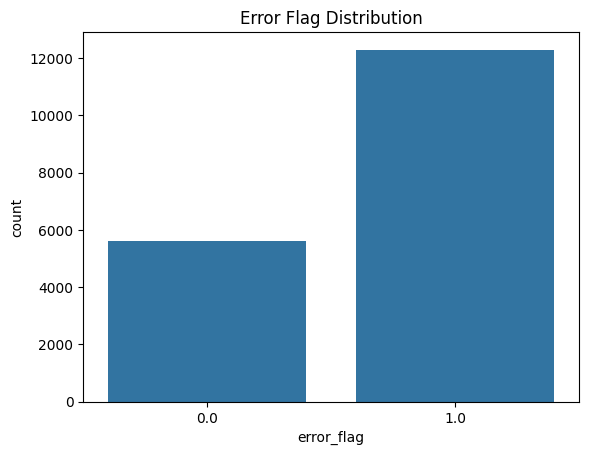

In [103]:
# ------------------------
# 3. Exploratory Data Analysis (EDA)

# Target distribution
sns.countplot(x='error_flag', data=df)
plt.title("Error Flag Distribution")
plt.show()

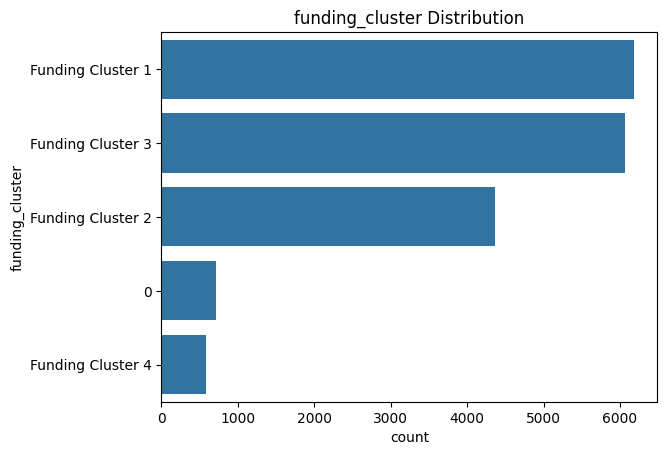

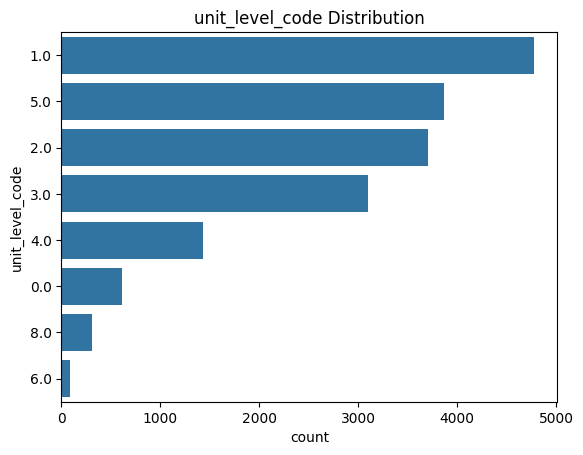

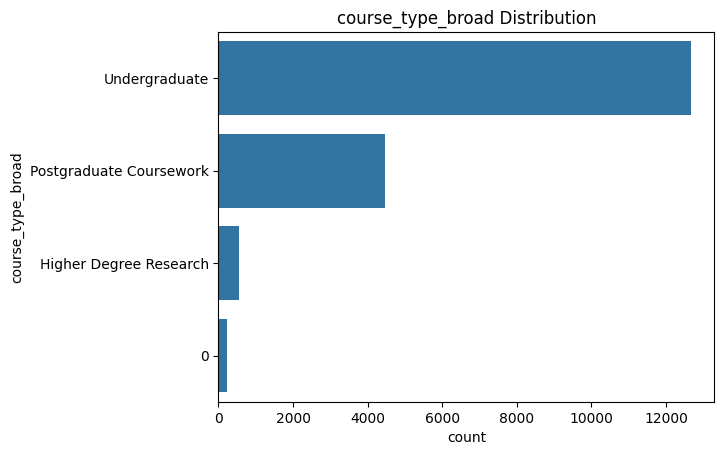

In [104]:
# Categorical feature distribution
categorical_cols = ['funding_cluster', 'unit_level_code', 'course_type_broad']
for col in categorical_cols:
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()

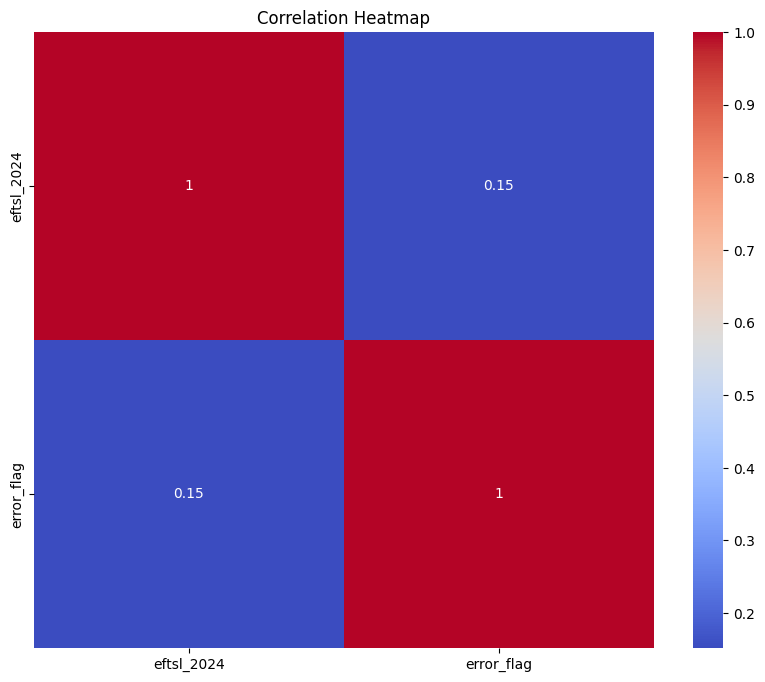

In [105]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols + ['error_flag']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [106]:
# ------------------------
# 4. Features & One-Hot Encoding
features = ['eftsl_2024', 'funding_cluster', 'unit_level_code', 'course_type_broad']
X = pd.get_dummies(df[features], drop_first=True)
y = df['error_flag']

In [107]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ------------------------
# 5. Scaling
scaler = StandardScaler(with_mean=False)  # works with dummy variables
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------
# 6. Logistic Regression
log_reg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

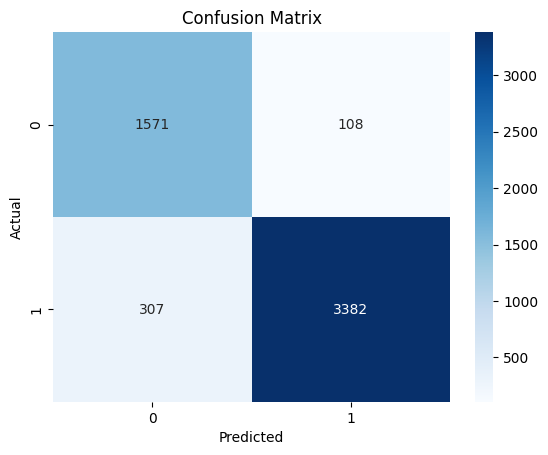

In [108]:
# ------------------------
# 7. Model Evaluation

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [109]:

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.941907036210707


In [110]:

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88      1679
         1.0       0.97      0.92      0.94      3689

    accuracy                           0.92      5368
   macro avg       0.90      0.93      0.91      5368
weighted avg       0.93      0.92      0.92      5368



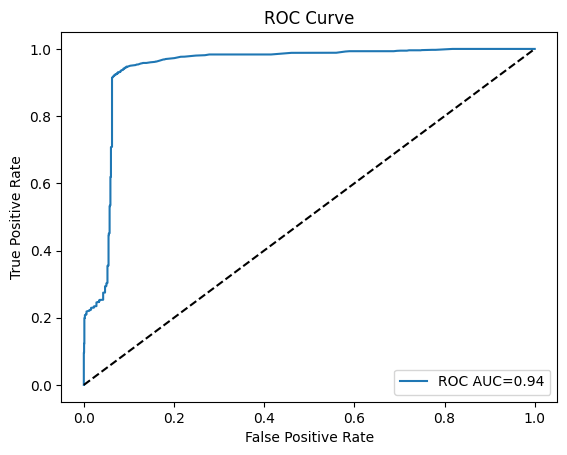

In [111]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

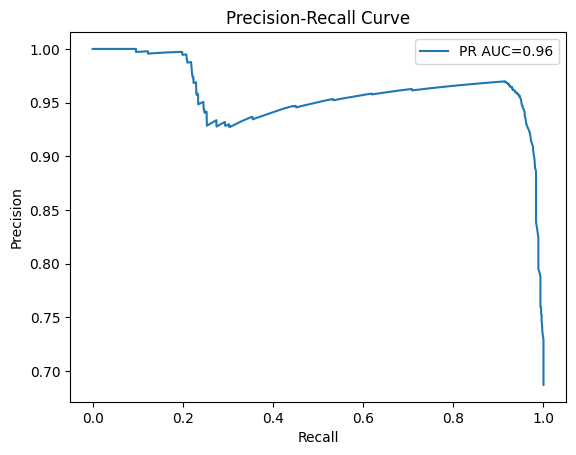

In [112]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

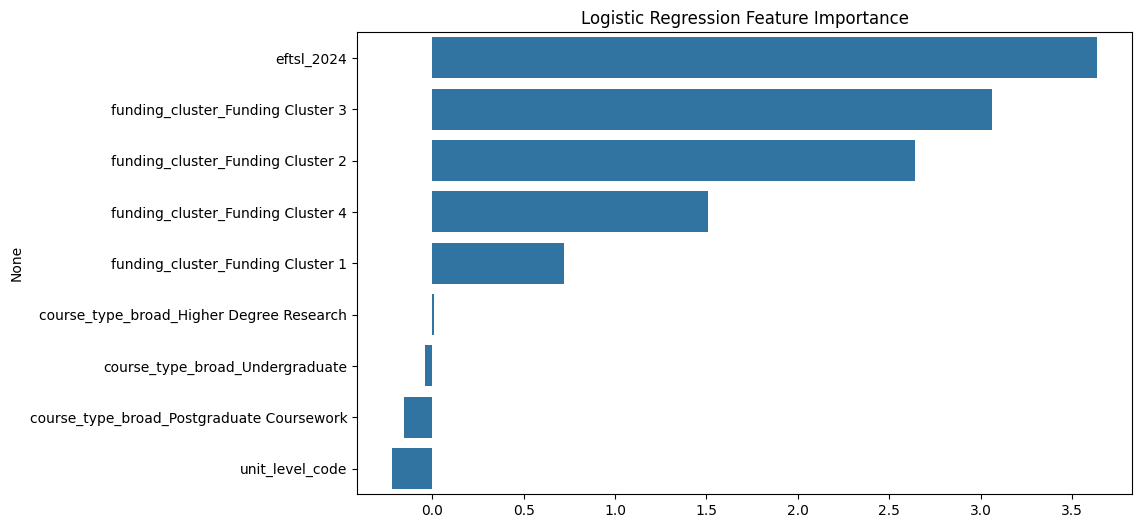

In [113]:

# ------------------------
# 8. Feature Importance
coefficients = pd.Series(log_reg.coef_[0], index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=coefficients.values, y=coefficients.index)
plt.title("Logistic Regression Feature Importance")
plt.show()

In [114]:
odds_ratios = np.exp(log_reg.coef_[0])
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0], 'Odds_Ratio': odds_ratios})
coeff_df = coeff_df.sort_values(by='Odds_Ratio', ascending=False)
print(coeff_df)



                                     Feature  Coefficient  Odds_Ratio
0                                 eftsl_2024     3.635356   37.915354
4          funding_cluster_Funding Cluster 3     3.060444   21.337035
3          funding_cluster_Funding Cluster 2     2.640992   14.027116
5          funding_cluster_Funding Cluster 4     1.508130    4.518273
2          funding_cluster_Funding Cluster 1     0.718612    2.051584
6   course_type_broad_Higher Degree Research     0.011097    1.011159
8            course_type_broad_Undergraduate    -0.042255    0.958625
7  course_type_broad_Postgraduate Coursework    -0.152249    0.858774
1                            unit_level_code    -0.219075    0.803261


In [115]:
# 9. Cross-Validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("CV ROC-AUC:", cv_scores.mean())

CV ROC-AUC: 0.9393457266323978


In [ ]:
# ------------------------
# 10. Save results for visualization / Power BI
results_df = X_test.copy()
results_df['True_Error'] = y_test.values
results_df['Predicted_Error'] = y_pred
results_df['Predicted_Probability'] = y_prob
results_df.to_csv('logistic_predictions.csv', index=False)